In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

In [2]:
%matplotlib inline

In [3]:
# data
var = 0.2
def func(x):
    return x

def gen_x():
    return np.sign(np.random.normal(0.,1.,[data_size,1]))

def gen_y(x):
    return func(x)+np.random.normal(0.,np.sqrt(var),[data_size,1])

data_size = 20000
x=gen_x()
y=gen_y(x)
p_y_x=np.exp(-(y-x)**2/(2*var))
p_y_x_minus=np.exp(-(y+1)**2/(2*var))
p_y_x_plus=np.exp(-(y-1)**2/(2*var))
mi=np.average(np.log(p_y_x/(0.5*p_y_x_minus+0.5*p_y_x_plus)))
print(mi)
mi_numerical = mutual_info_regression(x.reshape(-1, 1), y.ravel())[0]
print(mi_numerical)


0.659147527791
0.658305248838


In [4]:
## Tensorflow version for MINE (https://github.com/mzgubic/MINE/blob/master/MINE_in_TF.ipynb)

H=20
n_epochs = 200
data_size = 20000

def MINE(x_in, y_in):
    
    # shuffle and concatenate
    y_shuffle = tf.random_shuffle(y_in)
    x_conc = tf.concat([x_in, x_in], axis=0)
    y_conc = tf.concat([y_in, y_shuffle], axis=0)
    
    # propagate the forward pass
    layerx = layers.linear(x_conc, H)
    layery = layers.linear(y_conc, H)
    layer2 = tf.nn.relu(layerx + layery)
    output = layers.linear(layer2, 1)
    
    # split in T_xy and T_x_y predictions
    N_samples = tf.shape(x_in)[0]
    T_xy = output[:N_samples]
    T_x_y = output[N_samples:]
    
    # compute the negative loss (maximise loss == minimise -loss)
    neg_loss = -(tf.reduce_mean(T_xy, axis=0) - tf.math.log(tf.reduce_mean(tf.math.exp(T_x_y))))
    opt = tf.train.AdamOptimizer(learning_rate=0.01).minimize(neg_loss)

    return neg_loss, opt

# prepare the placeholders for inputs
x_in = tf.placeholder(tf.float32, [None, 1], name='x_in')
y_in = tf.placeholder(tf.float32, [None, 1], name='y_in')

# make the loss and optimisation graphs
neg_loss, opt = MINE(x_in, y_in)

# start the session
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# train
MIs = []
for epoch in range(n_epochs):
    
    # generate the data
    x_sample=gen_x()
    y_sample=gen_y(x_sample)
    
    # perform the training step
    feed_dict = {x_in:x_sample, y_in:y_sample}
    _, neg_l = sess.run([opt, neg_loss], feed_dict=feed_dict)
    
    # save the loss
    MIs.append(-neg_l)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [5]:
from mine import MINE

Using TensorFlow backend.


In [6]:
mine = MINE(x_dim=1, y_dim=1)

In [7]:
fit_history, mutual_info = mine.fit(x_sample, y_sample, epochs=200, verbose=0)

/home/chezhu/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


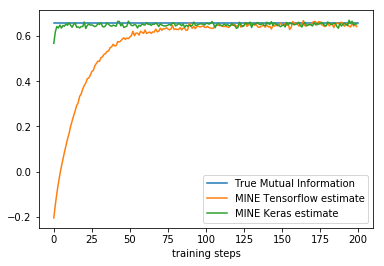

In [8]:
fig, ax = plt.subplots()
ax.plot([0, len(MIs)], [mi,mi], label='True Mutual Information')
ax.plot(range(len(MIs)), MIs, label='MINE Tensorflow estimate')
ax.plot(range(len(fit_history)), [-i for i in fit_history], label='MINE Keras estimate' )
ax.set_xlabel('training steps')
ax.legend(loc='best')
fig.show()